<div class="alert alert-info">
    <h1>Cervino: run simulations with Matterhorn</h1>
</div>

In [76]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of cervino.core.core failed: Traceback (most recent call last):
  File "/work/bfilippo/software/anaconda3/envs/cervino36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 244, in check
    superreload(m, reload, self.old_objects)
  File "/work/bfilippo/software/anaconda3/envs/cervino36/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 378, in superreload
    module = reload(module)
  File "/work/bfilippo/software/anaconda3/envs/cervino36/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/work/bfilippo/software/anaconda3/envs/cervino36/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 678, in exec_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "/work/bfilippo/cervino/cervino/core/core.py", line 17, in <mo

<div class="alert alert-info">
    <h2>Import packages</h2>
</div>

In [77]:
from pprint import pprint

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import segyio

In [79]:
# Set numerical precision
# DTYPE = np.float64

In [80]:
# Imports for Cervino
from cervino import *

<div class="alert alert-info">
    <h2>Cervino setup</h2>
</div>

General Cervino class which allows one to do most of the work. This class has methods to create the TOML file, the solver input file, to run the simulation, ...

In [81]:
marmousi = Cervino(name='marmousi_v10')

<div class="alert alert-info">
    <h2>General setup</h2>
</div>

In this initial section, we define a few general parameters required by the simulation.

In [82]:
general_dict = get_general_dict(solver='matterhorn',
                                desc='Matterhorn and marmousi',
                                site='euler')

In [83]:
general_dict

{'user': 'bfilippo',
 'site': 'euler',
 'solver': 'matterhorn',
 'desc': 'Matterhorn and marmousi'}

<div class="alert alert-info">
    <h2>Domain setup</h2>
</div>

In this section, we need to define the model used for the simulation. In the example below, we choose the original Marmousi model.

In [84]:
fn_h5 = marmousi_original(solver='matterhorn', overwrite=True)

This function will fetch the Marmousi model and prepare it for the chosen solver. To do so, it will create the directory 'marmousi_original_model' in the current working directory '/work/bfilippo/cervino/notebooks'.
The existing directory '/work/bfilippo/cervino/notebooks/marmousi_original_model' has been removed.
The archive 'marmousi_archive.tar.gz' already exists.


In [85]:
domain = AcousticDomain()

In [86]:
# Set the models
domain.set_model_from_hdf5(fn_h5, geometry=False)

marmousi_original_model/marmousi_original.h5


In [87]:
domain

In [88]:
# pprint(domain.get_domain_dict())

<div class="alert alert-info">
    <h2>Time and frequency setup</h2>
</div>

Here we need to define the time step in seconds `time_step_in_seconds` and the number of time steps `number_of_timesteps`. In the example below, we first define the time step, initial, and final time, and use these values to compute the number of time steps. However, one could also directly define the number of time steps.

In [89]:
time_step_in_seconds = 4e-4
start_time_in_seconds = 0.0
# time_shift_in_seconds = 1.0
end_time_in_seconds = 2.0

# Time axis
t = np.arange(start_time_in_seconds, end_time_in_seconds, time_step_in_seconds)

number_of_timesteps = t.size

In [90]:
# This will also become a function to be consistent with the other sections
time_dict = get_time_dict(ts=time_step_in_seconds, nt=number_of_timesteps)

In [91]:
# pprint(time_dict)

<div class="alert alert-info">
    <h2>Input setup</h2>
</div>

Here, we define the input (sources) which will generate the wavefields. We can define a single point source or an array (boundary) of point sources. In the example below, we define a point source characterised by a Ricker wavelet as source time function.

In [92]:
# Use a Ricker wavelet as source time function
center_frequency = 30.0
stf = RickerWavelet(t, fc=center_frequency, delay=1.5, delay_type='c')

Additionally, we can also load a user-defined wavelet from a binary file.

In [93]:
filename = 'user_defined_ricker_20hz.bin'
stf = UserWavelet(filename, nt=t.size)

In [94]:
# Define a point source
name = "source0"
location = (4000.0, 0.0, 20.0)
spatial_type = "fz"
scale = 1.

source0 = PointSource(loc=location, stf=stf, spatial_type=spatial_type)

In [95]:
# pprint(source0.get_source_dict())

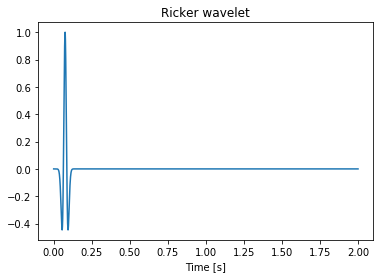

In [96]:
# Plot the source time function
# This will be implemented in the PointSource class
plt.plot(t, source0.stf.wavelet)
_ = plt.title('Ricker wavelet')
_ = plt.xlabel('Time [s]')

<div class="alert alert-info">
    <h2>Output setup</h2>
</div>

Here, we definte the output of the simulation. Now we create two shot gathers.

In [97]:
# First we create a general gather object
start_timestep = 0
end_timestep = 5000
timestep_increment = 10

gather = ShotGather(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [98]:
n = domain.get_domain_dict()['geometry']['number-of-cells']
d = domain.get_domain_dict()['geometry']['cell-size']

# Number of receivers
nr = n[0]
# Receiver z-value
rz0 = 40.0
# x-value of first receiver
rx0 = 0.0
# x-value of last receiver
rx1 = nr * d[0]

In [99]:
# Then we define multiple receiver arrays
rec0 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V01Z', filename='vz_gather')
# rec1 = gather.add_receivers(origin=(rx0, 0.0, rz0), increment=(d[0], 0.0, 0.0), nr=nr, attribute='V10X', filename='vx_gather')

Additionally, we create time snapshots.

In [100]:
# First we create a general snapshot object
start_timestep = 0
end_timestep = 5000
timestep_increment = 100

snapshot = TimeSlice(start_timestep=start_timestep, end_timestep=end_timestep, timestep_increment=timestep_increment, fmt='su')

In [101]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

In [102]:
# Then we define two slices
slice0 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V10X', filename='vx_slice')
slice1 = snapshot.add_slices(axis=slice_axis, slice_index=slice_index, attribute='V01Z', filename='vz_slice')

Additionally, we create DFT slices.

In [103]:
# First we create a general snapshot object
dft_frequencies = list(range(5, 81, 5))

dft = DFTSlice(dft_frequencies=dft_frequencies, fmt='su')

In [104]:
# Axis
slice_axis = 'y'
# Slice index
slice_index = 0

In [105]:
# Then we define two slices
dft_slice0 = dft.add_slices(axis=slice_axis, slice_index=slice_index, attribute='S00X', filename='sxx_dft_slice')

In [106]:
# pprint(gather.get_receivers_dict())
# pprint(snapshot.get_slices_dict())

<div class="alert alert-info">
    <h2>Physics setup</h2>
</div>

In [107]:
pml_dict = get_pml_dict(fs=True, width=10, power=4, frequency=center_frequency, vel=3000.)

In [108]:
physics_dict = get_physics_dict(order=4, boundaries=[pml_dict,])

In [109]:
# pprint(physics_dict)

<div class="alert alert-info">
    <h2>Generate TOML file</h2>
</div>

In [110]:
# Generate the complete input dictionary.
def get_input_file_dict():
    return {
        "general": general_dict,
        "domain": domain.get_domain_dict(),
        "time": time_dict,
        "physics": physics_dict,
        "source": {"point-source": [source0.get_source_dict(),]},
        "output": {
            "gather": gather.get_receivers_dict(),
            "slice_time": snapshot.get_slices_dict(),
            "slice_dft": dft.get_slices_dict(),
        }
    }

input_file_dict = get_input_file_dict()

# Thoughts:
# For now, the final complete input dictionary is created manually
# joining the required smaller sectional dictionaries.
# Is there a better way to do so?

In [111]:
input_file_dict

{'general': {'user': 'bfilippo',
  'site': 'euler',
  'solver': 'matterhorn',
  'desc': 'Matterhorn and marmousi'},
 'domain': {'dimension': 3,
  'geometry': {'origin': (0.0, 0.0, 0.0),
   'number-of-cells': (2301, 1, 751),
   'cell-size': (4.0, 4.0, 4.0)},
  'model': {'filename': 'marmousi_original_model/marmousi_original.h5',
   'format': 'hdf5',
   'required-models': ('vp', 'rho')}},
 'time': {'time-step-in-seconds': 0.0004, 'number-of-timesteps': 5000},
 'physics': {'spatial-operator': 'taylor_4',
  'boundaries': [{'type': 'pml',
    'freesurface': 'True',
    'pml-width-in-gridpoints': 10,
    'pml-power': 4,
    'pml-frequency': 30.0,
    'pml-damping-vel': 3000.0}]},
 'source': {'point-source': [{'location': (4000.0, 0.0, 20.0),
    'spatial-type': 'fz',
    'spatial-weights': 1.0,
    'source-time-function': {'wavelet': 'user',
     'filename-prefix': 'user_defined_ricker_20hz',
     'format': 'bin'}}]},
 'output': {'gather': {'start-timestep': 0,
   'end-timestep': 5000,
   't

In [112]:
# Create the Cervino input from a dictionary
marmousi.from_dict(input_file_dict)

In [113]:
pprint(marmousi.get_input_dict())

{'domain': {'dimension': 3,
            'geometry': {'cell-size': (4.0, 4.0, 4.0),
                         'number-of-cells': (2301, 1, 751),
                         'origin': (0.0, 0.0, 0.0)},
            'model': {'filename': 'marmousi_original_model/marmousi_original.h5',
                      'format': 'hdf5',
                      'required-models': ('vp', 'rho')}},
 'general': {'desc': 'Matterhorn and marmousi',
             'site': 'euler',
             'solver': 'matterhorn',
             'user': 'bfilippo'},
 'output': {'gather': {'end-timestep': 5000,
                       'format': 'su',
                       'receivers': [{'attribute': 'V01Z',
                                      'filename-prefix': 'vz_gather',
                                      'number-of-receivers': 2301,
                                      'receiver-increment': (4.0, 0.0, 0.0),
                                      'receiver-origin': (0.0, 0.0, 40.0)}],
                       'start-timestep': 

In [114]:
# Create the Cervino input from a TOML file
# marmousi.from_toml('marmousi_for_cervino.toml')

In [115]:
# pprint(marmousi.get_input())

In [116]:
# Look at the file we've written
# Linux
# !cat "marmousi_for_cervino.toml"
# Windows
# !type "marmousi_for_cervino.toml"

<div class="alert alert-info">
    <h2>Run simulation</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

This launches the simulation on the local workstation/laptop.

In [117]:
# mh_file = marmousi.to_solver_input()

In [118]:
# mh_file

In [59]:
# !cat marmousi_v10.sim

<grid>
origin 0.0 0.0 0.0
number_of_cells 2301 1 751
cell_size 4.0 4.0 4.0
</grid>

<decomposition>
number_of_nodes 1 1 1
number_of_cells_per_node_x 2301
number_of_cells_per_node_y 1
number_of_cells_per_node_z 751
</decomposition>

<time>
number_of_timesteps 5000
timestep_size 0.0004
</time>

<model>
type acoustic
format bin
filename_prefix marmousi_original_model/marmousi_original
</model>

<simulation>
type acoustic_2d
order_time_operator 2
spatial_operator taylor_4
freesurface True
bc_type pml
pml_width_in_gridpoints 10
pml_power 4
pml_frequency 30.0
pml_damping_vel 3000.0
</simulation>

<input>
type z_source
location 4000.0 0.0 20.0
wavelet user
spread trilinear
scale_factor 1.0
filename_prefix user_defined_ricker_20hz
format bin
</input>

<output>
type shot_gather
format su
start_timestep 0
end_timestep 5000
timestep_increment 10
attribute V01Z
filename_prefix vz_gather
receiver_origin 0.0 0.0 40.0
number_of_receivers 2301
receiver_increment 4.0 0.0 0.0
</output>

<output>
type sl

In [45]:
run_dict = {
    'solver_binary': 'matterhorn',
    'progress': True,
    'verbose': False,
    'ncores': 24
}

In [47]:
result = marmousi.run(run_dict)

In [119]:
marmousi._site

'cluster'

<div class="alert alert-info">
    <h3>Matterhorn (Euler)</h3>
</div>


* Create submission script
* Copy the file to Euler
* Submit the job to the queue
* Obtain the JOB ID
* Check the status of the job
* If the job is running, start the progress bar
* Retrive the output files

## Important!
This section requires that the model files are already on Euler. I will modify this soon.

In [120]:
run_dict = {
    'solver_binary': 'matterhorn',
    'progress': True,
    'verbose': False,
    'ncores': 24,
    'dir_remote': '/cluster/scratch/bfilippo/cervino',
    'fn_submission_script': 'script.sh',
    'job_name': marmousi.name,
}

In [121]:
run_dict

{'solver_binary': 'matterhorn',
 'progress': True,
 'verbose': False,
 'ncores': 24,
 'dir_remote': '/cluster/scratch/bfilippo/cervino',
 'fn_submission_script': 'script.sh',
 'job_name': 'marmousi_v10'}

In [123]:
jobid = marmousi.run(run_dict)

The jobid is 99585959


In [129]:
bjobs_dict = marmousi.check_status()

The status of the job 99585959 is DONE.


In [130]:
pprint(bjobs_dict)

OrderedDict([('JOBID', '99585959'),
             ('USER', 'bfilipp'),
             ('STAT', 'DONE'),
             ('QUEUE', 'normal.4h'),
             ('FROM_HOST', 'eu-login-15'),
             ('EXEC_HOST', '24*eu-c7-07'),
             ('JOB_NAME', '*mousi_v10'),
             ('SUBMIT_TIME', 'Sep 5 16:18')])


In [132]:
bjobs_dict = marmousi.fetch(dir_local='./euler')

<div class="alert alert-info">
    <h2>Pipeline</h2>
</div>

<div class="alert alert-info">
    <h3>2D line</h3>
</div>

In [ ]:
# Define a list of source locations
# source_locations = [(2000.0, 0.0, 20.0), (4000.0, 0.0, 20.0), (6000.0, 0.0, 20.0)]
source_locations = [(float(x), 0.0, 20.0) for x in range(2000, 6000, 2000)]
pprint(source_locations)

In [ ]:
# Create the Pipeline object
marmousi_pipeline = Pipeline(marmousi)

In [ ]:
# TO DO:
# 1) Create many input files DONE
# 2) Change the source location DONE
# 3) Add a suffix at the end of the filename_prefix of the outputs DONE
# 4) Keep track of the input files and the output files DONE

from collections import OrderedDict

pipeline_dict = OrderedDict()
# Specify the task: create a 2D line of shot gather
pipeline_dict['2d_line'] = source_locations

marmousi_2d_line = marmousi_pipeline.create(pipeline_dict)

In [ ]:
marmousi_pipeline

In [ ]:
# Execute the pipeline
marmousi_pipeline.run()

<div class="alert alert-info">
    <h2>Show results</h2>
</div>

<div class="alert alert-info">
    <h3>Matterhorn (local)</h3>
</div>

In [ ]:
filename = 'vz_gather.su'
# with segyio.open(filename, ignore_geometry=True) as segyfile:
sufile = segyio.su.open(filename, ignore_geometry=True, endian='little')
sufile.mmap()

In [ ]:
clip = 1e-9
vmin, vmax = -clip, clip

# Figure
figsize=(10, 15)
ndim = 1
fig, axs = plt.subplots(nrows=1, ncols=ndim, figsize=figsize, facecolor='w', edgecolor='k', squeeze=False)

axs = axs.ravel()

axs[0].imshow(sufile.trace.raw[:].T, cmap=plt.cm.seismic, vmin=vmin, vmax=vmax, aspect=1)
_ = axs[0].set_xlabel('Horizontal location')
_ = axs[0].set_ylabel('Time [s]')

# plt.savefig('gather.png', dpi=300, bbox_inches='tight')

In [ ]:
sufile.close()